## Interpretability Script!
This script is to explore the relative contributions of the MJO & ENSO (indices) to prediction of z500 in the North Pacific (part of the PNA) 

## Prep for analysis

In [3]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import tensorflow as tf
from Gordon_interp import getoutputvecs, confvacc, iconfcorr
from trainGordon_utils import subset, build_model, fullmodel, scheduler, plot_results
import importlib
import sys

# importlib.reload(sys.modules["Gordon_interp"])
# from Gordon_interp import getoutputvecs, confvacc, iconfcorr
# importlib.reload(sys.modules["trainGordon_utils"])
# from trainGordon_utils import subset, build_model, fullmodel, scheduler, plot_results

2023-07-27 14:51:25.443382: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-27 14:51:26.377235: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-07-27 14:51:26.727019: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-07-27 14:51:57.495410: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

ModuleNotFoundError: No module named 'trainGordon_utils'

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt

plt.rc('text',usetex=True)
plt.rcParams['font.family']='sans-serif'
plt.rcParams['font.sans-serif']=['Verdana']
plt.rcParams.update({'font.size': 15})
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
            ax.xaxis.set_ticks([])
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['figure.dpi'] = 150
dpiFig = 300.

In [ ]:
DIR = '/glade/u/home/wmanriquez/workdir/MJO_ENSO_indices/' 

X1_FINAME = 'SST_ENSO_CESM_obs_500_800_full_TS.nc'
X2_FINAME = 'MJO_CESM_OLR_obs_500_800_full_TS.nc'
Y_FINAME  = 'Z500_CESM_500_800_full_TS.nc'


MODEL_FINAME = 'NN_weights.h5'
MODEL_DIR = '/glade/u/home/wmanriquez/workdir/MJO_ENSO_indices/'


LEAD = 14 #days

### Prep data:

In [ ]:
# TRAINING - reloading to get mean & std
# predictors [time]
X1train = xr.open_dataset(DIR+X1_FINAME)['TS_SST_ONI'][:100*365]

X2trainRMM1 = xr.open_dataset(DIR+X2_FINAME)['RMM1_cera20c'][:100*365]
X2trainRMM2 = xr.open_dataset(DIR+X2_FINAME)['RMM2_cera20c'][:100*365]
X2train = xr.concat([X2trainRMM1,X2trainRMM2], dim = 'new_dim') # 2xtime
del X2trainRMM1, X2trainRMM2
X1train = X1train[:-1*LEAD] 
X2train = X2train[:,:-1*LEAD] 

# predictand [time]
Ytrain = xr.open_dataset(DIR+Y_FINAME)['Z500a_r7'][:100*365]
Ytrain = Ytrain[LEAD:]

# ---------- mean & standard deviation from Xtrain ----------
X1mean = X1train.groupby('time.dayofyear').mean()
X1std = X1train.groupby('time.dayofyear').std()
X2mean = X2train.groupby('time.dayofyear').mean()
X2std = X2train.groupby('time.dayofyear').std()

# ---------- median from Ytrain ----------
Ymed = Ytrain.quantile(q=.5,dim='time')

del X1train, X2train, Ytrain

In [ ]:
# TESTING
X1test = xr.open_dataset(DIR+X1_FINAME)['TS_SST_ONI'][200*365:]

X2testRMM1 = xr.open_dataset(DIR+X2_FINAME)['RMM1_cera20c'][200*365:]
X2testRMM2 = xr.open_dataset(DIR+X2_FINAME)['RMM2_cera20c'][200*365:]
X2test = xr.concat([X2testRMM1,X2testRMM2], dim = 'new_dim') # 2xtime
del X2testRMM1, X2testRMM2
X1test = X1test[:-1*LEAD] 
X2test = X2test[:,:-1*LEAD] 

Ytest = xr.open_dataset(DIR+Y_FINAME)['Z500a_r7'][200*365:]
Ytest = Ytest[LEAD:]

In [ ]:
# check that Y and X1/2 are the same size
# ----- code here -----

In [ ]:
# NOTE: we standardize training, validation and testing using the TRAINING mean & std (or median)

# TESTING STANDARDIZATION
X1test_norm = (X1test.groupby('time.dayofyear')- X1mean).groupby('time.dayofyear')/(X1std)
X2test_norm = (X2test.groupby('time.dayofyear')- X2mean).groupby('time.dayofyear')/(X2std)
Ytest_norm = Ytest - Ymed

# turn Ys into 0s and 1s
Ytest_norm[Ytest_norm<=0] = 0 
Ytest_norm[Ytest_norm>0] = 1

# subset predictand (and predictors) to same number of 0s and 1s
n_testzero = np.shape(np.where(Ytest_norm==0)[0])[0]
n_testone  = np.shape(np.where(Ytest_norm==1)[0])[0]
i_testzero = np.where(Ytest_norm==0)[0]
i_testone  = np.where(Ytest_norm==1)[0]

# look into the "subset" function and learn how it works
X1test_norm, Ytest_norm, i_testnew = subset(X1test_norm, Ytest_norm, n_testzero, n_testone, i_testzero, i_testone)
X2test_norm = X2test_norm.isel(time = i_testnew,drop=True)

# convert data from xarray to numpy
X1_test = X1test_norm.T.values
X2_test = X2test_norm.T.values

Y_test = Ytest_norm.values

In [ ]:
N=10 #days to go "back in time" 

#clunky bad loop: 
for ee,num in enumerate(reversed(range(N + 1))):
    X1_test_back = X1_test[num:-(ee+1)] 
    X2_test_back = X2_test[num:-(ee+1),:]
    if ee==0:
        X1_test_norm_mem=X1_test[num:-(ee+1)]
        X2_test_norm_mem=X2_test[num:-(ee+1),:]
    else: 
        X1_test_norm_mem = np.vstack([X1_test_back,X1_test_norm_mem])
        X2_test_norm_mem = np.concatenate([X2_test_back,X2_test_norm_mem],axis=1)
        
Y_test_mem=Y_test[N:-1] #adjust Ytarget.... 
X1_test_norm_mem = X1_test_norm_mem.T

In [9]:
# check data looks good
# ----- code here -----

### Load network:

In [10]:
# variables:
# As a good starting point, look at Gordon et al. (in prep) to identify what values she uses for these parameters 
# NOTE - we are inputing a value, not a map, so we likely need a much smaller network
SEED = 1 #dont touch!!
DROPOUT_RATE = 0 #mess with

MODELNAME1 = 'ENSO'
RIDGE1 = 0 #dont touch!!
HIDDENS1 = [8] #play
INPUT_SHAPE1 = 11   #with memory == N+1 

MODELNAME2 = 'MJO'
RIDGE2 = 0 #dont touch
HIDDENS2 = [8] #play
INPUT_SHAPE2 = 22 #with memory == (N+1)*2

In [11]:
# ENSO MODEL
model1, input1 = build_model(SEED,
                             DROPOUT_RATE,
                             RIDGE1,
                             HIDDENS1,
                             INPUT_SHAPE1,
                             MODELNAME1)


# MJO MODEL
model2, input2 = build_model(SEED,
                             DROPOUT_RATE,
                             RIDGE2,
                             HIDDENS2,
                             INPUT_SHAPE2,
                             MODELNAME2)   

# COMBINE ENSO & MJO MODEL
model = fullmodel(model1, model2,
                  input1, input2,
                  SEED)

2023-07-24 11:12:57.490350: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-24 11:12:58.102302: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15078 MB memory:  -> device: 0, name: Quadro GP100, pci bus id: 0000:18:00.0, compute capability: 6.0


In [12]:
# load model weights here!
model.load_weights(MODEL_DIR+MODEL_FINAME)

## Interpret:

### How does the network perform on testing data?

In [13]:
rawpred = model.predict((X1_test_norm_mem,X2_test_norm_mem))
conf = np.max(rawpred,axis=-1)
predval = np.argmax(rawpred,axis=-1)

1138/1138 [==============================] - 2s 1ms/step


In [14]:
rawpred

array([[0.46071753, 0.5392825 ],
       [0.46136135, 0.5386386 ],
       [0.46169883, 0.53830117],
       ...,
       [0.45561492, 0.5443851 ],
       [0.45696434, 0.5430356 ],
       [0.45933914, 0.54066086]], dtype=float32)

In [31]:
predval

array([1, 1, 1, ..., 1, 1, 1])

In [32]:
conf

array([0.5392825 , 0.5386386 , 0.53830117, ..., 0.5443851 , 0.5430356 ,
       0.54066086], dtype=float32)

In [33]:
# is it more accurate at higher confidence?
conf_acc, conf_percision, conf_recall = confvacc(confval = conf,
                                                 predval = predval,
                                                 Ytest   = Y_test_mem)

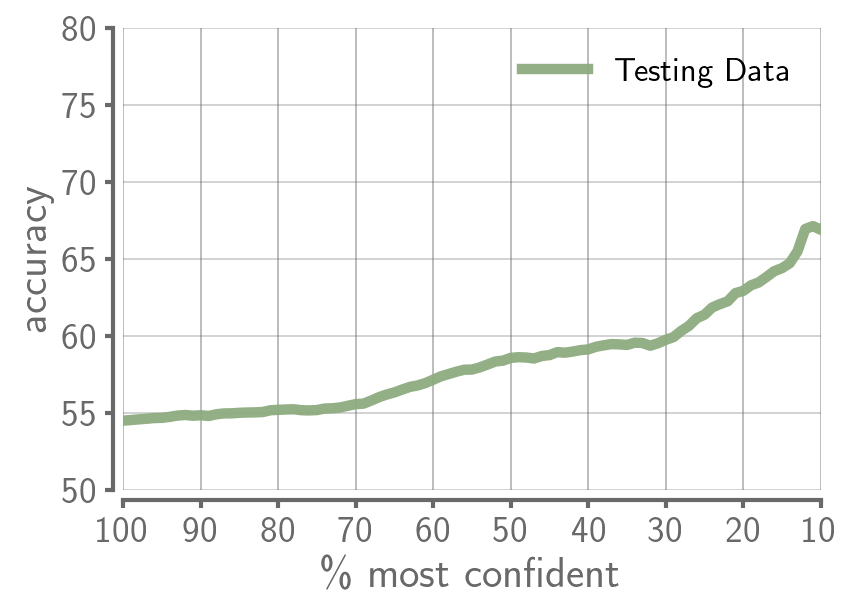

In [34]:
valColor = (141/255,171/255,127/255,1.)
FS = 18
plt.figure(figsize=(6, 4))

#---------- plot loss -------------------
ax = plt.subplot(1,1,1)
adjust_spines(ax, ['left', 'bottom'])
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_color('dimgrey')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)


plt.plot(conf_acc, '-', color=valColor, alpha=0.95,linewidth=5,label='Testing Data')

plt.xlabel('\% most confident',fontsize=FS+3,color='dimgrey')
plt.ylabel('accuracy',fontsize=FS+3,color='dimgrey')
plt.xticks(np.arange(0,110,10),labels=np.arange(0,100+10,10)[::-1],fontsize=FS,color='dimgrey')
plt.yticks(np.arange(50,85,5),labels=np.arange(50,85,5),fontsize=FS,color='dimgrey')
plt.grid(True)
plt.legend(frameon=False, fontsize=FS-2, loc='best',ncol=2)
plt.xlim(0, 90)
plt.ylim(50,80)

plt.show()

### Let's look at last layer model contributions:

In [19]:
model1_contribution, model2_contribution = getoutputvecs(model,
                                                         model1,
                                                         model2,
                                                         X1_test_norm_mem,
                                                         X2_test_norm_mem)

# model 1 winning class (model 1 output * weight)
model1pred = np.argmax(model1_contribution,axis=1)
# model 2 winning class (model 2 output * weight)
model2pred = np.argmax(model2_contribution,axis=1)

1138/1138 [==============================] - 1s 885us/step


In [20]:
print('--- ENSO Model Contribution to Final Layer ---')
print(model1_contribution[:10])
print(model1pred[:10])
print('\n--- MJO Model Contribution to Final Layer ---')
print(model2_contribution[:10])
print(model2pred[:10])

--- ENSO Model Contribution to Final Layer ---
[[-0.07771301  0.07033484]
 [-0.07782919  0.07044028]
 [-0.0779568   0.07055611]
 [-0.07809979  0.07068589]
 [-0.07826033  0.0708316 ]
 [-0.0784436   0.07099795]
 [-0.07865674  0.07119139]
 [-0.07889882  0.07141109]
 [-0.07916607  0.07165365]
 [-0.07945611  0.07191691]]
[1 1 1 1 1 1 1 1 1 1]

--- MJO Model Contribution to Final Layer ---
[[-3.7133850e-03  5.6931707e-03]
 [-1.7812671e-03  4.8125335e-03]
 [-5.8503961e-04  4.4074175e-03]
 [-5.6923769e-04  4.6092994e-03]
 [ 8.6646137e-04  4.0687462e-03]
 [ 4.9550296e-03  2.3531301e-03]
 [ 9.1642030e-03 -2.2823540e-05]
 [ 1.3626782e-02 -3.0123431e-03]
 [ 1.6826615e-02 -5.5176215e-03]
 [ 1.4858673e-02 -5.2063460e-03]]
[1 1 1 1 1 0 0 0 0 0]


In [21]:
# Where ENSO model (model 1), ...  
i_model1corr = model1pred==Y_test_mem
# ... MJO model (model 2), ...
i_model2corr = model2pred==Y_test_mem
# ... and final/total model are correct
i_modelcorr  = predval==Y_test_mem

In [22]:
# model (raw/confidence) values when correct
model1_corr = model1_contribution[i_model1corr] # these are NOT "confidence" - no softmax value
model2_corr = model2_contribution[i_model2corr] # these are NOT "confidence" - no softmax value
model_corr  = rawpred[i_modelcorr]

In [36]:
i_model1corr

array([False, False, False, ...,  True,  True,  True])

In [23]:
# terminology: "win" = modelX prediction is also (correct) full model prediction

# model 1 correct & model correct (model 2 not correct)
i_model1win = i_model1corr & i_modelcorr & ~i_model2corr
# model 2 correct & model correct (model 1 not correct)
i_model2win = i_model2corr & i_modelcorr & ~i_model1corr

# model 1&2 correct & model correct
i_model12win = i_model1corr & i_model2corr & i_modelcorr

In [24]:
# For correct predictions: model(X) values & predicted class when also full model prediction
model1win_contribution = model1_contribution[i_model1win]
model1win_predval = model1pred[i_model1win]

model2win_contribution = model2_contribution[i_model2win]
model2win_predval = model2pred[i_model2win]

model12win_predval = rawpred[i_model12win]

In [25]:
# these shapes should be equal (True), assuming ~i_model1corr & ~i_model2corr & i_modelcorr doesnt happen
model_corr.shape[0] == model1win_predval.shape[0] + model2win_predval.shape[0] + model12win_predval.shape[0]

True

In [26]:
# Percentage of model predictions correct due to just ENSO:
model1_fracpred = (model1win_predval.shape[0]/model_corr.shape[0]) *100
print('Percentage of predictions correct due to only ENSO: \n'+str(np.round(model1_fracpred,2))+'%')
# Percentage of model predictions correct due to just MJO:
model2_fracpred = (model2win_predval.shape[0]/model_corr.shape[0]) *100
print('Percentage of predictions correct due to only MJO: \n'+str(np.round(model2_fracpred,2))+'%')

# Percentage of model predictions correct from ENSO & MJO:
model12_fracpred = (model12win_predval.shape[0]/model_corr.shape[0]) *100
print('Percentage of predictions correct due to ENSO & MJO: \n'+str(np.round(model12_fracpred,2))+'%')

Percentage of predictions correct due to only ENSO: 
45.96%
Percentage of predictions correct due to only MJO: 
1.6%
Percentage of predictions correct due to ENSO & MJO: 
52.44%


In [1]:
model1_plot = model1pred
model2_plot = model2pred

truth_plot = Y_test_mem
truth_plot[truth_plot==0] += 0.25
truth_plot[truth_plot==1] -= 0.25

model1_plot[model1_plot==0] += 0.125
model1_plot[model1_plot==1] -= 0.125

NameError: name 'model1pred' is not defined

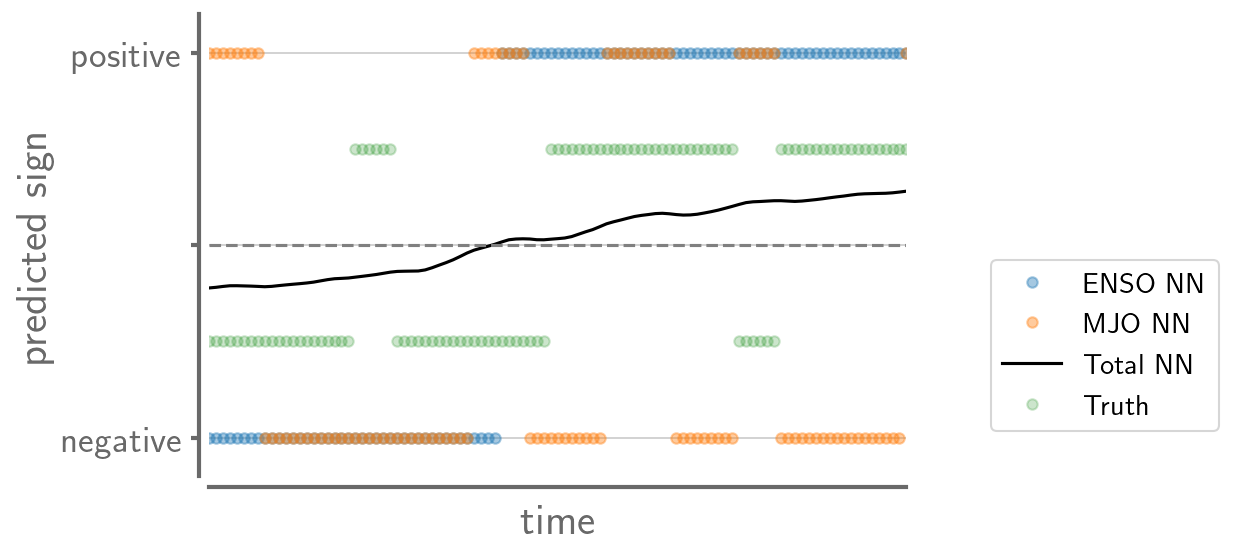

In [101]:
#---------------------------------------------------
valColor = (141/255,171/255,127/255,1.)
FS = 18

#---------- plot prediction = 0 -------------------
plt.figure(figsize=(6, 4))
ax = plt.subplot(1,1,1)
adjust_spines(ax, ['left', 'bottom'])
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_color('dimgrey')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)

plt.plot(model1_plot,linewidth=0,marker='.',markersize=10,alpha=0.4,label='ENSO NN')
plt.plot(model2_plot,linewidth=0,marker='.',markersize=10,alpha=0.4,label='MJO NN')
plt.plot(rawpred[:,1],'k',label='Total NN') # when >0.5 - network predicts postive
plt.plot(truth_plot,'g',linewidth=0,marker='.',markersize=10,alpha=0.2,label='Truth')
plt.axhline(xmin=0,xmax=500,y=0.5,linestyle='--',color='grey')

plt.xlabel('time',fontsize=FS+3,color='dimgrey')
plt.ylabel('predicted sign',fontsize=FS+3,color='dimgrey')
# plt.title('...',fontsize=FS+4,color='dimgrey')
plt.xticks(np.arange(0,550,50),labels=np.arange(0,550,50),fontsize=FS,color='dimgrey')
plt.yticks(np.arange(0,1.5,0.5),labels=['negative','','positive'],fontsize=FS,color='dimgrey')
plt.grid(True)
plt.legend(frameon=True, fontsize=FS-4, bbox_to_anchor=(1.1, 0.5),ncol=1)
plt.xlim(34350, 34450)
plt.ylim(-0.1,1.1)

# SAVE ME!!!!!!!

plt.show()


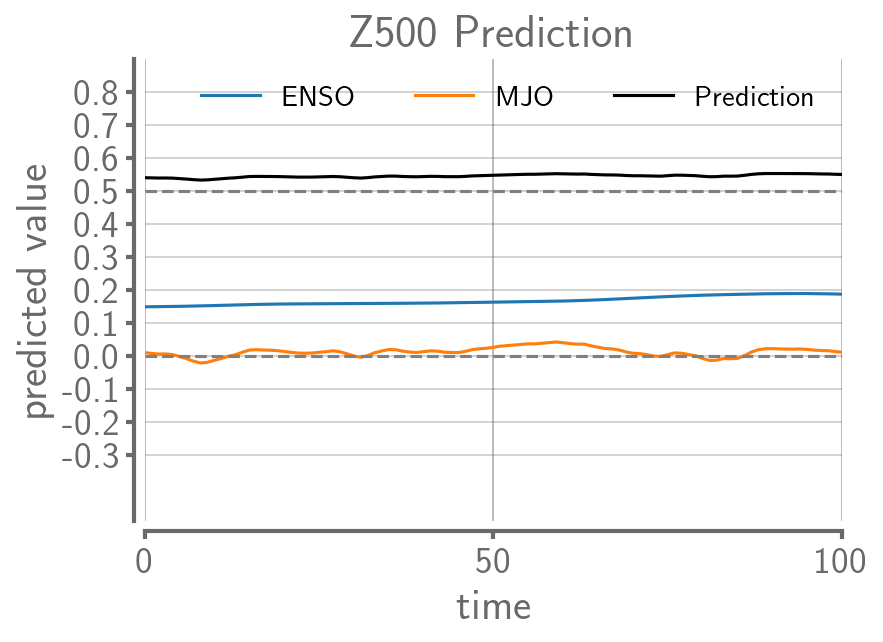

In [67]:
# NOT USING THIS FOR POSTER/PRESENTATION:
# Plot model 1 and model 2 contributions to (values summed to get) output before softmax

model1_diff = model1_contribution[:500,1] - model1_contribution[:500,0]
model2_diff = model2_contribution[:500,1] - model2_contribution[:500,0]

#---------------------------------------------------
valColor = (141/255,171/255,127/255,1.)
FS = 18

#---------- plot prediction = 0 -------------------
plt.figure(figsize=(6, 4))
ax = plt.subplot(1,1,1)
adjust_spines(ax, ['left', 'bottom'])
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_color('dimgrey')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)

plt.plot(model1_diff,label='ENSO')
plt.plot(model2_diff,label='MJO')
plt.axhline(xmin=0,xmax=500,y=0.0,linestyle='--',color='grey')
plt.plot(rawpred[:500,1],'k',label='Prediction') # when >0.5 - network predicts postive
plt.axhline(xmin=0,xmax=500,y=0.5,linestyle='--',color='grey')

plt.xlabel('time',fontsize=FS+3,color='dimgrey')
plt.ylabel('predicted value',fontsize=FS+3,color='dimgrey')
plt.title('Z500 Prediction',fontsize=FS+4,color='dimgrey')
plt.xticks(np.arange(0,550,50),labels=np.arange(0,550,50),fontsize=FS,color='dimgrey')
plt.yticks(np.arange(-0.3,0.9,0.1),labels=[-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],fontsize=FS,color='dimgrey')
plt.grid(True)
plt.legend(frameon=False, fontsize=FS-4, loc='best',ncol=3)
plt.xlim(0, 100)
plt.ylim(-.5,.9)
plt.show()

### UNCLEAR IF USEFUL:

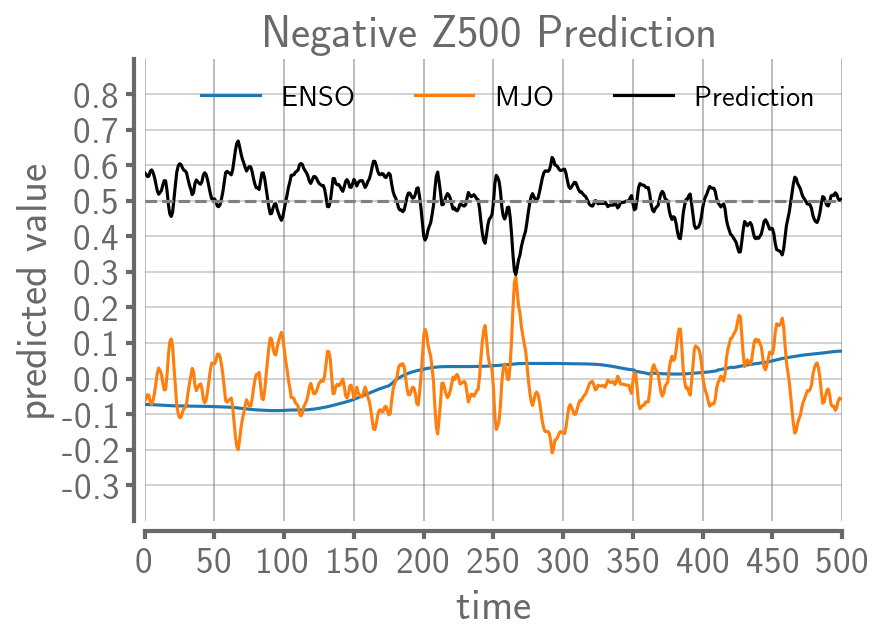

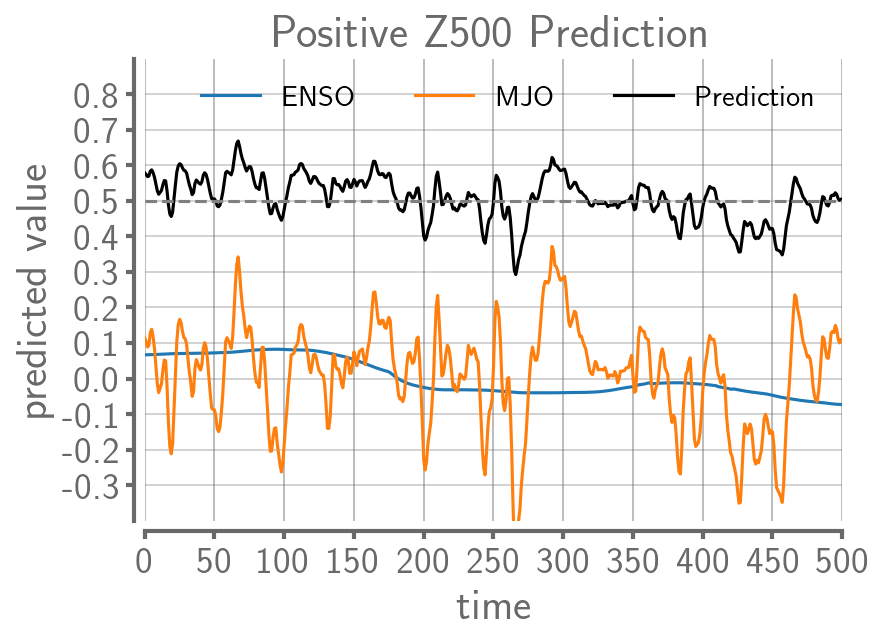

In [95]:
# Plot model 1 and model 2 contributions to (values summed to get) output before softmax

model1_lowval = model1_contribution[:500,0]
model2_lowval = model2_contribution[:500,0]

model1_highval = model1_contribution[:500,1]
model2_highval = model2_contribution[:500,1]

#---------------------------------------------------
valColor = (141/255,171/255,127/255,1.)
FS = 18

#---------- plot prediction = 0 -------------------
plt.figure(figsize=(6, 4))
ax = plt.subplot(1,1,1)
adjust_spines(ax, ['left', 'bottom'])
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_color('dimgrey')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)

plt.plot(model1_lowval,label='ENSO')
plt.plot(model2_lowval,label='MJO')
plt.plot(rawpred[:500,1],'k',label='Prediction') # when >0.5 - network predicts postive
plt.axhline(xmin=0,xmax=500,y=0.5,linestyle='--',color='grey')

plt.xlabel('time',fontsize=FS+3,color='dimgrey')
plt.ylabel('predicted value',fontsize=FS+3,color='dimgrey')
plt.title('Negative Z500 Prediction',fontsize=FS+4,color='dimgrey')
plt.xticks(np.arange(0,550,50),labels=np.arange(0,550,50),fontsize=FS,color='dimgrey')
plt.yticks(np.arange(-0.3,0.9,0.1),labels=[-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],fontsize=FS,color='dimgrey')
plt.grid(True)
plt.legend(frameon=False, fontsize=FS-4, loc='best',ncol=3)
plt.xlim(0, 500)
plt.ylim(-.4,.9)
plt.show()


#---------- plot prediction=1 -------------------
plt.figure(figsize=(6, 4))
ax = plt.subplot(1,1,1)
adjust_spines(ax, ['left', 'bottom'])
ax.spines['top'].set_color('none')
ax.spines['right'].set_color('none')
ax.spines['left'].set_color('dimgrey')
ax.spines['bottom'].set_color('dimgrey')
ax.spines['left'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)

plt.plot(model1_highval,label='ENSO')
plt.plot(model2_highval,label='MJO')
plt.plot(rawpred[:500,1],'k',label='Prediction') # when >0.5 - network predicts postive
plt.axhline(xmin=0,xmax=500,y=0.5,linestyle='--',color='grey')

plt.xlabel('time',fontsize=FS+3,color='dimgrey')
plt.ylabel('predicted value',fontsize=FS+3,color='dimgrey')
plt.title('Positive Z500 Prediction',fontsize=FS+4,color='dimgrey')
plt.xticks(np.arange(0,550,50),labels=np.arange(0,550,50),fontsize=FS,color='dimgrey')
plt.yticks(np.arange(-0.3,0.9,0.1),labels=[-0.3,-0.2,-0.1,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8],fontsize=FS,color='dimgrey')
plt.grid(True)
plt.legend(frameon=False, fontsize=FS-4, loc='best',ncol=3)
plt.xlim(0, 500)
plt.ylim(-.4,.9)
plt.show()

# NOTES:
# Looks like the MJO causes day to day changes in predictions, whereas ENSO has influence over time

### Lets look at the state of ENSO and MJO when the NN is correct & confident

In [136]:
# get locations of correct & confident predictions for total model:
i_conf_predval, i_corrconf_predval = iconfcorr(confval = conf,
                                               predval = predval,
                                               Ytest   = Y_test_mem,
                                               per = 80)

In [32]:
# ENSO index (+10 days before) when ENSO model correctly predicts sign & total network also predicts that sign 
ENSOstate = X1_test_norm_mem[effectofmodel1]

# RMM index (+10 days before) when MJO model correctly predicts sign & total network also predicts that sign 
RMM1state = X2_test_norm_mem[effectofmodel2,:11]
RMM2state = X2_test_norm_mem[effectofmodel2,11:]

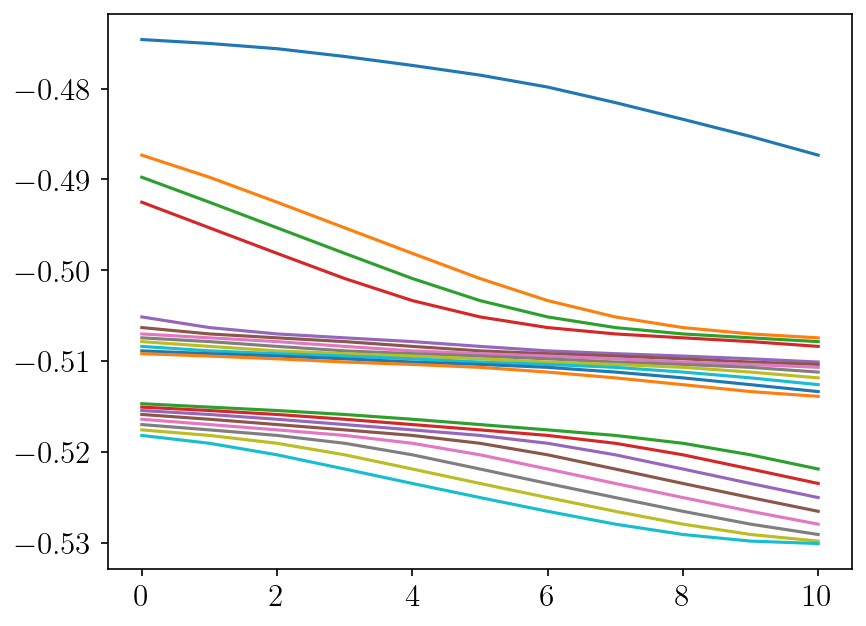

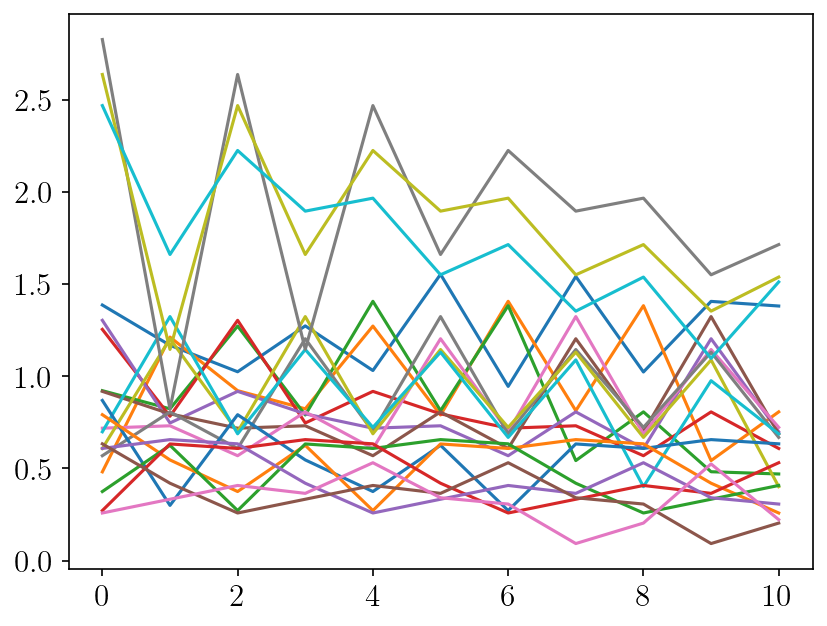

In [33]:
for i in range(20):
    plt.plot(ENSOstate[i])
plt.show()

for i in range(20):
    RMMamp = np.sqrt((RMM1state[i]**2) + (RMM2state[i]**2))
    plt.plot(RMMamp)
plt.show()